# Case 1 - Ordinary Least Squares (OLS), Ridge Regression, and Elastic-Net Regression

1. **Importing Libraries**

2. **Ordinary Least Squares (OLS)**

3. **Ridge (L2) Regression**

4. **Lasso (L1) Regression**

5. **Predicting $\hat{y}$ in the new data set (case1Data_Xnew.csv) using a weighted average of the predictions from the Lasso regression models**

## 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set searborn as default

import scipy . linalg as lng

from sklearn import linear_model

from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

import warnings

# Set seed for reproducibility
import random
random.seed(42)

## 2. Ordinary Least Squares (OLS)

In [2]:
# Loading the data into numpy arrays
X = np.loadtxt('../data/case1Data_X.csv', delimiter=',')
y = np.loadtxt('../data/case1Data_y.csv', delimiter=',')

# Function to solve the OLS
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    return betas, res, rnk, s

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

#### Outer loop ####
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #### Data Preprocessing ####

    # Convert the numpy arrays to pandas DataFrames
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # Using StandardScaler from scikit-learn to standardize the data
    scaler = StandardScaler()

    # Standardizing the numerical features (all columns exept the last five)
    X_train.iloc[:, :95] = scaler.fit_transform(X_train.iloc[:, :95])
    X_test.iloc[:, :95] = scaler.transform(X_test.iloc[:, :95])

    # class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
    continuous_imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, :95] = pd.DataFrame(continuous_imputer.fit_transform(X_train.iloc[:, :95]))
    X_test.iloc[:, :95] = pd.DataFrame(continuous_imputer.transform(X_test.iloc[:, :95]))

    # Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, -5:] = categorical_imputer.fit_transform(X_train.iloc[:, -5:])
    X_test.iloc[:, -5:] = categorical_imputer.transform(X_test.iloc[:, -5:])
    
    # One-hot encoding the categorical variables using get_dummies from pandas library (for the last five columns)
    X_train = pd.get_dummies(X_train, columns=X_train.columns[-5:])
    X_test = pd.get_dummies(X_test, columns=X_test.columns[-5:])

    # Align the columns of the training and test data
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Convert the pandas DataFrames back to numpy arrays
    X_train = np.asarray(X_train, dtype=np.float64)
    X_test = np.asarray(X_test, dtype=np.float64)

    #### Inner loop ####

    with warnings.catch_warnings():  # Suppress convergence warnings
        warnings.simplefilter("ignore")
        rmse_scores_inner = []
        for train_idx_inner, test_idx_inner in inner_cv.split(X_train, y_train):
            X_train_inner, X_test_inner = X_train[train_idx_inner], X_train[test_idx_inner]
            y_train_inner, y_test_inner = y_train[train_idx_inner], y_train[test_idx_inner]

            # Solve the OLS on the inner training set
            betas, _, _, _ = ols_solver(X_train_inner, y_train_inner)

            # Evaluate on the inner test set
            y_pred_inner = X_test_inner @ betas

            # Calculate the RMSE
            rmse_inner = np.sqrt(mean_squared_error(y_test_inner, y_pred_inner))
            rmse_scores_inner.append(rmse_inner)

            # Saving the optimal model
            if rmse_inner == min(rmse_scores_inner):
                best_betas_inner = betas

    #### Evaluation ####

    # Predicting the target values on the test set using the optimal model
    y_pred = X_test @ best_betas_inner

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Saving the optimal model
    if rmse == min(rmse_scores):
        best_betas = best_betas_inner

    # Print the results of the inner loop
    print(f'Fold RMSE: {rmse:.4f}')

# Final performance
print(f'Average RMSE across outer folds: {np.mean(rmse_scores):.4f}')
# Standard deviation of the RMSE tells us how much the RMSE varies between the folds (i.e., how stable the model is)
print(f'Standard deviation of RMSE: {np.std(rmse_scores):.4f}')


Fold RMSE: 43.0342
Fold RMSE: 47.3337
Fold RMSE: 27.8152
Fold RMSE: 52.0384
Fold RMSE: 38.2795
Average RMSE across outer folds: 41.7002
Standard deviation of RMSE: 8.3053


# 3. Ridge (L2) Regression

In [3]:
# Loading the data into numpy arrays
X = np.loadtxt('../data/case1Data_X.csv', delimiter=',')
y = np.loadtxt('../data/case1Data_y.csv', delimiter=',')

# Setting k for the number of lambdas to test
k = 1000

# Creating a list of lambdas to test
lambdas = np.logspace(-1, 4, k)

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

#### Outer loop ####
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    #### Data Preprocessing ####

    # Convert the numpy arrays to pandas DataFrames
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # Using StandardScaler from scikit-learn to standardize the data
    scaler = StandardScaler()

    # Standardizing the numerical features (all columns exept the last five)
    X_train.iloc[:, :95] = scaler.fit_transform(X_train.iloc[:, :95])
    X_test.iloc[:, :95] = scaler.transform(X_test.iloc[:, :95])

    # class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
    continuous_imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, :95] = pd.DataFrame(continuous_imputer.fit_transform(X_train.iloc[:, :95]))
    X_test.iloc[:, :95] = pd.DataFrame(continuous_imputer.transform(X_test.iloc[:, :95]))

    # Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, -5:] = categorical_imputer.fit_transform(X_train.iloc[:, -5:])
    X_test.iloc[:, -5:] = categorical_imputer.transform(X_test.iloc[:, -5:])
    
    # One-hot encoding the categorical variables using get_dummies from pandas library (for the last five columns)
    X_train = pd.get_dummies(X_train, columns=X_train.columns[-5:])
    X_test = pd.get_dummies(X_test, columns=X_test.columns[-5:])

    # Align the columns of the training and test data
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Convert the pandas DataFrames back to numpy arrays
    X_train = np.asarray(X_train, dtype=np.float64)
    X_test = np.asarray(X_test, dtype=np.float64)

    #### Inner loop ####
    with warnings.catch_warnings():  # Suppress convergence warnings
        warnings.simplefilter("ignore")
        # Fit the Ridge regression model on the training set using cross-validation to find the optimal lambda
        model = RidgeCV(alphas=lambdas, store_cv_values=False, cv=5).fit(X_train, y_train)

    #### Evaluation ####

    # Predicting the target values on the test set using the optimal model
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Saving the optimal model
    if rmse == min(rmse_scores):
        best_model = model

    # Print the results of the inner loop
    print(f'Fold RMSE: {rmse:.4f}')

# Final performance
print(f'Average RMSE across outer folds: {np.mean(rmse_scores):.4f}')
# Standard deviation of the RMSE tells us how much the RMSE varies between the folds (i.e., how stable the model is)
print(f'Standard deviation of RMSE: {np.std(rmse_scores):.4f}')

Fold RMSE: 31.2889
Fold RMSE: 32.0780
Fold RMSE: 27.4197
Fold RMSE: 37.2727
Fold RMSE: 31.5272
Average RMSE across outer folds: 31.9173
Standard deviation of RMSE: 3.1458


# 4. Lasso (L1) Regression

In [13]:
# Loading the data into numpy arrays
X = np.loadtxt('../data/case1Data_X.csv', delimiter=',')
y = np.loadtxt('../data/case1Data_y.csv', delimiter=',')

# Setting the range of alphas to test
alphas = np.logspace(-4, 1, 100)

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
models = []
alpha_list = []

#### Outer loop ####
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    #### Data Preprocessing ####

    # Convert the numpy arrays to pandas DataFrames
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # Using StandardScaler from scikit-learn to standardize the data
    scaler = StandardScaler()

    # Standardizing the numerical features (all columns exept the last five)
    X_train.iloc[:, :95] = scaler.fit_transform(X_train.iloc[:, :95])
    X_test.iloc[:, :95] = scaler.transform(X_test.iloc[:, :95])

    # class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
    continuous_imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, :95] = pd.DataFrame(continuous_imputer.fit_transform(X_train.iloc[:, :95]))
    X_test.iloc[:, :95] = pd.DataFrame(continuous_imputer.transform(X_test.iloc[:, :95]))

    # Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, -5:] = categorical_imputer.fit_transform(X_train.iloc[:, -5:])
    X_test.iloc[:, -5:] = categorical_imputer.transform(X_test.iloc[:, -5:])
    
    # One-hot encoding the categorical variables using get_dummies from pandas library (for the last five columns)
    X_train = pd.get_dummies(X_train, columns=X_train.columns[-5:])
    X_test = pd.get_dummies(X_test, columns=X_test.columns[-5:])

    # Align the columns of the training and test data
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Convert the pandas DataFrames back to numpy arrays
    X_train = np.asarray(X_train, dtype=np.float64)
    X_test = np.asarray(X_test, dtype=np.float64)

    # Inner loop for hyperparameter tuning (5-fold CV)
    with warnings.catch_warnings():  # Suppress convergence warnings
        warnings.simplefilter("ignore")
        # Fit the Lasso regression model on the training set using cross-validation to find the optimal
        model = LassoCV(cv=5, alphas=alphas, fit_intercept=False, random_state=42).fit(X_train, y_train)

        # Save the optimal penalization
        alpha = model.alpha_

    #### Evaluation ####

    # Predicting the target values on the test set using the optimal model
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Saving the model and the alpha
    models.append(model)
    alpha_list.append(alpha)

    # Saving the optimal model
    if rmse == min(rmse_scores):
        best_model = model

    # Print the results of the inner loop
    print(f'Fold RMSE: {rmse:.4f}')

# Final performance
print(f'Average RMSE across outer folds: {np.mean(rmse_scores):.4f}')
# Standard deviation of the RMSE tells us how much the RMSE varies between the folds (i.e., how stable the model is)
print(f'Standard deviation of RMSE: {np.std(rmse_scores):.4f}')

Fold RMSE: 26.1366
Fold RMSE: 23.3240
Fold RMSE: 26.3223
Fold RMSE: 25.8996
Fold RMSE: 29.8694
Average RMSE across outer folds: 26.3104
Standard deviation of RMSE: 2.0873


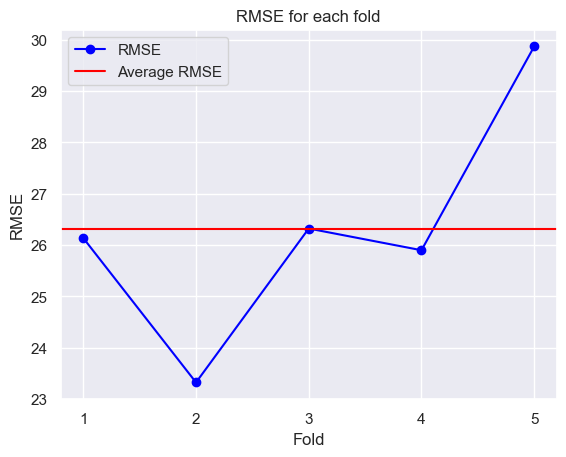

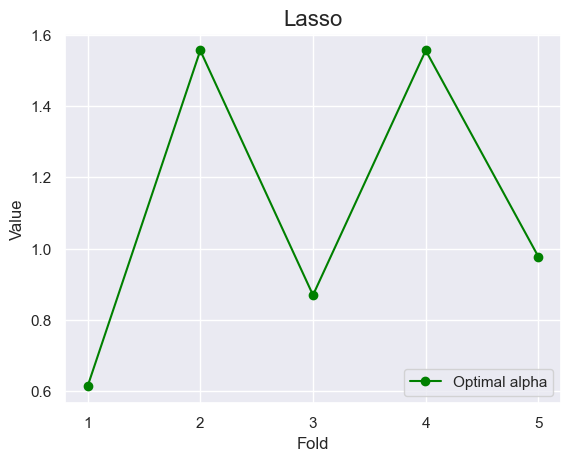

In [15]:
# Plotting the RMSE scores, optimal alpha and optimal l1_ratio for each fold
plt.close('all')
plt.figure()
plt.plot(rmse_scores, 'o-', label='RMSE', color='blue')
plt.axhline(np.mean(rmse_scores), label='Average RMSE', color='red')
plt.xlabel('Fold')
plt.xticks(np.arange(5), np.arange(1, 6))
plt.ylabel('RMSE')
plt.title('RMSE for each fold')
plt.legend()
plt.savefig('../plots/lasso_RMSE.png')
plt.show()

plt.close('all')
plt.figure()
plt.plot(alpha_list, 'o-', label='Optimal alpha', color='green')
plt.xticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Fold')
plt.ylabel('Value')
plt.title('Lasso', fontsize=16)
plt.legend()
plt.savefig('../plots/lasso_alpha.png')
plt.show()

## 5. Predicting $\hat{y}$ in the new data set (case1Data_Xnew.csv) using a weighted average of the predictions from the Lasso regression models

### Loading case1Data_Xnew_wrangled.csv

In [16]:
# Loading the data into numpy arrays
X_new = np.loadtxt('../data/case1Data_Xnew_wrangled.csv', delimiter=',')
print("X_new: ", X_new.shape)

X_new:  (1000, 116)


### Predicting and saving predictions in a new file

In [17]:
#### Predicting y_hat for the data in case1Data_Xnew.csv using a weighted ensemble of the models ####

# Computing inverse RMSE weights for the models (the lower the RMSE, the higher the weight)
inverse_rmse = 1 / np.array(rmse_scores)

# Closing the weights to sum up to 1
weights = inverse_rmse / np.sum(inverse_rmse)

# Printing the weights
print(f'RMSE: {rmse_scores}')
print(f'Inverse RMSE: {inverse_rmse}')
print(f'Weights: {weights}')
print(f'Sum of weights: {np.sum(weights)}')

# Computing weighted ensemble prediction
y_hat_new_ensemble = np.zeros(X_new.shape[0])
for model, weight in zip(models, weights):
    y_hat_new_ensemble += weight * model.predict(X_new)

# Saving the predictions to a csv file
np.savetxt('../results/sample_predictions_s183220_s225001.csv', y_hat_new_ensemble, fmt='%.4f', delimiter='\n')

RMSE: [26.136577563066943, 23.324008463554453, 26.32233310330283, 25.89964533431513, 29.869367756869206]
Inverse RMSE: [0.03826056 0.04287428 0.03799055 0.03861057 0.03347912]
Weights: [0.20009174 0.22422018 0.1986797  0.2019222  0.17508618]
Sum of weights: 0.9999999999999999


### Writing the Estimated RMSE to File

In [18]:
# We will use the average RMSE across the outer folds as the expected RMSE
# Saving the value as float with 2 decimals precision
print(f'Expected RMSE: {np.mean(rmse_scores):.2f}')
np.savetxt('../results/sample_estimatedRMSE_s183220_s225001.csv', [np.mean(rmse_scores)], fmt='%.2f')

Expected RMSE: 26.31
